In [3]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
import time

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device('cpu')
print(device)

cuda:0


In [5]:
torch.manual_seed(10)
np.random.seed(10)

In [6]:
split_ratio = 0.7 # train : (test + validate)
batch_size = 32

## Loading the Dataset
**Dataset:** Animal 10 \
**Image Dimensions:** (224, 224, 3) \
**No. of classes:** 10 \
**Classes:** [dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, elephant]

In [7]:
data_dir = '/kaggle/input/animals10/raw-img'
classes = { "cane": "dog",
            "cavallo": "horse",
            "elefante": "elephant",
            "farfalla": "butterfly",
            "gallina": "chicken", 
            "gatto": "cat",
            "mucca": "cow",
            "pecora": "sheep",
            "ragno": "spider",
            "scoiattolo": "squirrel"
          }
class_name = { 0: "dog",
                 1: "horse",
                 2: "elephant",
                 3: "butterfly",
                 4: "chicken", 
                 5: "cat",
                 6: "cow",
                 7: "sheep",
                 8: "spider",
                 9: "squirrel"
              }


transform = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [9]:
labels = dataset.targets
print(f'Total no. of samples = {len(labels)}\n')
for (id, name) in class_name.items():
    print(f'{name}: {labels.count(id)} : {labels.count(id)*100/len(labels)}%')

Total no. of samples = 26179

dog: 4863 : 18.57595782879407%
horse: 2623 : 10.019481263608236%
elephant: 1446 : 5.5235112112762135%
butterfly: 2112 : 8.067535047175216%
chicken: 3098 : 11.833912678100768%
cat: 1668 : 6.371519156575881%
cow: 1866 : 7.127850567248558%
sheep: 1820 : 6.952137209213491%
spider: 4821 : 18.415523893196838%
squirrel: 1862 : 7.112571144810726%


In [10]:
train_size = int(split_ratio*len(dataset))
test_size = int((len(dataset) - train_size)/2)
validation_size = len(dataset) - (train_size + test_size)
print(f'Train size = {train_size}, Test size = {test_size}, Validation size = {validation_size}')

train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_size, test_size, validation_size])

Train size = 18325, Test size = 3927, Validation size = 3927


## Displaying Images from the dataset

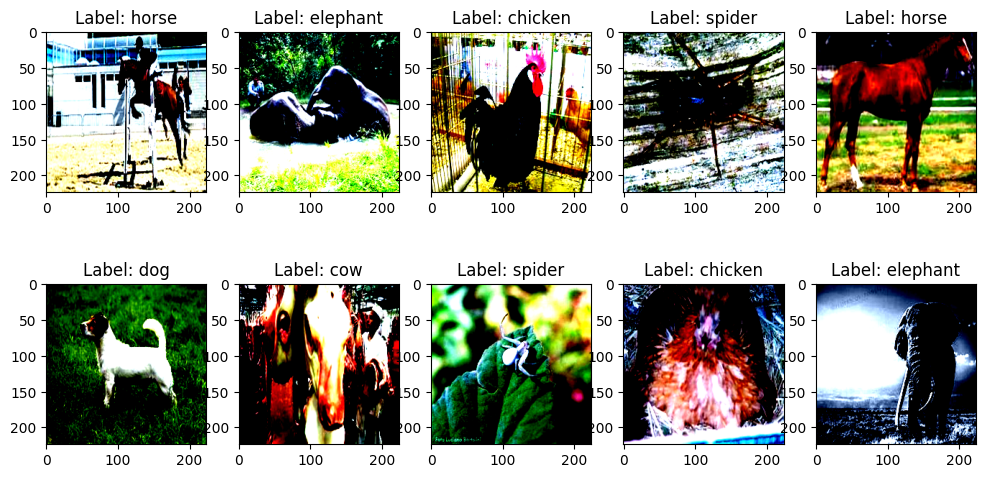

In [11]:
random_indices = np.random.choice(len(train_dataset), 10, replace=False)
sample_data = train_dataset[0]

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img, label = train_dataset[idx]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'Label: {class_name[label]}')

plt.show()

## Model
* Input size: (3, 224, 224)
* Latent size: 32x7x7

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main path
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Residual path with 1x1 convolutional layer to match dimensions
        self.residual_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.residual_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x

        # Main path
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # Residual path
        residual = self.residual_conv(residual)
        residual = self.residual_bn(residual)

        # Summing the main path and the residual path
        x += residual
        x = self.relu(x)

        return x

In [13]:
class Model_v2(nn.Module):
    
    def __init__(self, out_size=10):
        super().__init__()
        
        latent_size = 512*7*7
        self.feature_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # without pretrained weights
        # Replacing the last fully connected layer of resnet with a new one with the desired size
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(num_features, latent_size)

        
        self.classifier = nn.Sequential(
            nn.Linear(latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, out_size),
        )

        self.heatmap_generator = nn.Sequential(
            ResidualBlock(512, 256),
            ResidualBlock(256, 128),
            ResidualBlock(128, 64),
            ResidualBlock(64, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        latent_vect = self.feature_extractor(x)
        output = self.classifier(latent_vect)
        reshaped_latent_vect = latent_vect.view(latent_vect.shape[0], 512, 7, 7) 
        heatmap = self.heatmap_generator(reshaped_latent_vect)
        return output, heatmap
    
# model_v2 = Model_v2()

In [15]:
class Model(nn.Module):
    
    def __init__(self, out_size=10):
        super().__init__()
        
        latent_size = 32*7*7
        self.feature_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # without pretrained weights
        
        # Replacing the last fully connected layer of resnet with a new one with the desired size
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(num_features, latent_size)

        
        self.classifier = nn.Sequential(
            nn.Linear(latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, out_size),
        )

        
#         self.heatmap_generator = nn.Sequential(
#             nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 14) : (C, H, W)
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 28, 28)
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 56, 56)
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Output: (32, 112, 112)
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # Output: (1, 224, 224)
#             nn.Tanh()
#         )
        self.heatmap_generator = nn.Sequential(
            nn.Linear(latent_size, 3000),
            nn.ReLU(),
            nn.Linear(3000, 224*224),
            nn.Tanh()         
        )
    
#     def forward(self, x):
#         latent_vect = self.feature_extractor(x)
#         output = self.classifier(latent_vect)
#         # Reshape the latent_vector => (batch_size, latent_size, 1, 1)
#         latent_vect = latent_vect.view(latent_vect.shape[0], 32, 7, 7) 
#         heatmap = self.heatmap_generator(latent_vect)
#         return output, heatmap

    def forward(self, x):
        latent_vect = self.feature_extractor(x)
        output = self.classifier(latent_vect)
        heatmap = self.heatmap_generator(latent_vect)
        # Reshape the heatmap => (batch_size, 1, 224, 224)
        heatmap = heatmap.view(latent_vect.shape[0], 1, 224, 224)
        return output, heatmap
    
model = Model()

In [ ]:
model.parameters()

# for name, param in model.named_parameters():
#     print(f"{name}: {param.size()}")

In [16]:
def check_gradients(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()}: ", end="")
        if param.grad is not None:
            print(f'{torch.max(param.grad.data)}, {torch.min(param.grad.data)}')

In [17]:
def view_heatmaps(model, dataset, n_examples=2):
    model.eval()
    indices = np.random.choice(len(dataset), n_examples)
    for i in indices:
        img, label = dataset[i]
        img = img.to(device)
        output, heatmap = model(img.unsqueeze(0))
        heatmap = theshold_heatmap(heatmap)
        energy_map = heatmap.squeeze()*img
        print(output)
        y_pred = torch.argmax(output, dim=1).detach().item()
        print(y_pred)
        print(f'Predicted Label: {class_name[y_pred]}, Actual Label: {class_name[label]}')

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(img.cpu().permute(1, 2, 0))

        plt.subplot(1, 3, 2)
        plt.title('Heatmap')
        plt.imshow(heatmap.cpu().detach().squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Energy Map')
        plt.imshow(energy_map.cpu().detach().squeeze().permute(1, 2, 0))
        plt.show()

In [18]:
def make_plots(losses, accuracies):
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses)), losses)
    plt.title("Loss plot")

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(accuracies)), accuracies)
    plt.title("Accuracy plot")
    
    plt.show()

In [19]:
def test_model(model, test_dataset):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=128)
    with torch.no_grad():
        correct_count = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output, heatmap = model(images)
            _, y_pred = torch.max(output, dim=1)
            correct_count += torch.sum(y_pred == labels).item()
    
        acc = correct_count/len(test_dataset)
    print(f'Test accuracy = {acc}')

In [20]:
def test_model_detailed(model, test_dataset, n_samples=10):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=n_samples)
    count = 0
    with torch.no_grad():
        correct_count = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output, heatmap = model(images)
            heatmap = threshold_heatmap(heatmap)
            energy_map = heatmap*images
            output_em, _ = model(energy_map)
            _, y_pred = torch.max(output, dim=1)
            correct_count += torch.sum(y_pred == labels).item()
#             if count < 10:
#                 temp = (y_pred == labels) & (labels != 0) & (labels != 8)
#                 count += torch.sum(temp)
                
                
#                 images = images[temp]
#                 y_pred = y_pred[temp]
#                 output = output[temp]
#                 output_em = output_em[temp]
#                 labels = labels[temp]
#                 heatmap = heatmap[temp]
#                 energy_map = energy_map[temp]
                
            for j in range(len(y_pred)):
                
                print(f'Predicted Label: {class_name[y_pred[j].item()]}, Actual Label: {class_name[labels[j].item()]}')
                print(f'Output: {output[j]}')
                print(f'Output_em: {output_em[j]}')
                print(f'Diff: {torch.abs(output[j] - output_em[j])}')
                print(f'Heatmap min = {torch.min(heatmap[j])}, max = {torch.max(heatmap[j])}')
#                 print(f'\nHeatmap L1 norm: {torch.norm(heatmap[j], p=1)} \n(min = {torch.min(heatmap[j])}, max = {torch.max(heatmap[j])}, mean = {heatmap[j].mean()}, std = {heatmap[j].std()})')
#                 print(heatmap[j].mean())
#                 heatmap[j] = normalize(heatmap[j].cpu().detach())
#                 heatmap[j] = nn.functional.normalize(heatmap[j].cpu().detach())
#                 print(f'\nHeatmap L1 norm (after normalization): {torch.norm(heatmap[j], p=1)} \n(min = {torch.min(heatmap[j])}, max = {torch.max(heatmap[j])}, mean = {heatmap[j].mean()}, std = {heatmap[j].std()})')
#                 print(heatmap[j].mean())

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.title('Image')
                plt.imshow(images[j].cpu().permute(1, 2, 0))

                plt.subplot(1, 3, 2)
                plt.title('Heatmap')
                plt.imshow(heatmap[j].cpu().detach().squeeze(), cmap='gray')
#                 plt.imshow(heatmap[j].cpu().detach().squeeze(), cmap='viridis')

                plt.subplot(1, 3, 3)
                plt.title('Energy Map')
                plt.imshow((images[j]*heatmap[j]).cpu().detach().squeeze().permute(1, 2, 0))
                plt.show()
                
#             print(heatmap[0])
#             print(heatmap[1])
#             print(heatmap[3])
            break

## Training

In [21]:
# Spatial smoothness loss
def smoothness_loss(x):    
    horizontal_diff = x[:, :, :, 1:] - x[:, :, :, :-1]
    vertical_diff = x[:, :, 1:, :] - x[:, :, :-1, :]

    loss = torch.sum(torch.abs(horizontal_diff)) + torch.sum(torch.abs(vertical_diff))
    return loss

In [22]:
# Encourage diversity in heatmap
def diversity_loss(x):
    mean_activation = torch.mean(x, dim=(2, 3), keepdim=True)
    diversity_loss = torch.mean(torch.abs(x - mean_activation))
    return diversity_loss

In [29]:
def threshold_heatmap(heatmap):
    
    shape = heatmap.shape

    heatmap = heatmap.view(heatmap.shape[0], -1)
    mins = heatmap.min(dim=1)[0].unsqueeze(1).unsqueeze(1).unsqueeze(1)
    maxs = heatmap.max(dim=1)[0].unsqueeze(1).unsqueeze(1).unsqueeze(1)
    heatmap = heatmap.view(shape)

    heatmap = (heatmap - mins) / (maxs - mins + 1e-10) # normalizing
    
    mean = torch.mean(heatmap, dim=(2,3), keepdim=True)
    heatmap[heatmap < mean] = 0
    return heatmap

In [30]:
def train(model, train_dataset, validation_dataset, batch_size=64, lr=0.01, max_epochs=50, load_checkpoint=False, checkpoint_path=None,
         w=[10, 100, 1e-5]):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9) 
    CE = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()
    L1 = nn.L1Loss()
    normalize = torchvision.transforms.Normalize(0, 1)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    start_time = time.time()
    
    if load_checkpoint:
        print(f'Loading checkpoint: {checkpoint_path}')
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        accuracies = checkpoint['accuracies']
    else:
        epoch = 0
        losses = []
        accuracies = []
        
    model.to(device)
        
    for epoch in range(epoch, max_epochs):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        progress_bar = tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}')
        running_loss = 0
        
        model.train()
        # Update Loop
        for i, (images, labels) in enumerate(train_loader):
        
            images = images.to(device)
            labels = labels.to(device)
            
#             output, heatmap = model(images)
#             energy_map = heatmap*images
#             output_em, _ = model(energy_map)

            output, heatmap = model(images)
            heatmap = threshold_heatmap(heatmap)
            energy_map = heatmap*images
            output_em, _ = model(energy_map)
            
            optimizer.zero_grad()
            
#             print(f'CE: {CE(output, labels)}, MSE: {MSE(output_em, output)}, L1: {torch.norm(heatmap, p=1)}')
            loss = CE(output, labels) # Cross Entropy Classification loss
            loss += CE(output_em, labels)
            loss += MSE(output_em, output) # Label Preservation MSE
#             loss += smoothness_loss(heatmap)
            loss += -diversity_loss(heatmap) # encourages diversity in heatmap
            
            loss += L1(heatmap, torch.zeros_like(heatmap).to(device))
#             loss += 100*sum([torch.norm(param, p=2) for param in model.heatmap_generator.parameters()]).to(device)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.detach().item()
            progress_bar.update(1)
            
        progress_bar.close()
        
        model.eval()
        # Evaluation loop: on validation set
        with torch.no_grad():
            correct_count = 0
            print('Entering evaluation loop...')
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                output, heatmap = model(images)
                _, y_pred = torch.max(output, dim=1)
                correct_count += torch.sum(y_pred == labels).item()
            
        accuracies.append(correct_count/len(validation_dataset))
        losses.append(running_loss/len(train_loader))
            
        # Storing the model every epochs
        if checkpoint_path is None:
            checkpoint_path = f"checkpoint_{datetime.now().strftime('%d-%m-%y:%H-%M-%S')}.pt"
        print(f'Storing checkpoint at {checkpoint_path}')
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'losses': losses,
            'accuracies': accuracies
        }
        torch.save(checkpoint, checkpoint_path)
        
        print(f'Epoch [{epoch + 1}/{max_epochs}]: loss = {running_loss/len(train_loader)}, accuracy = {correct_count/len(validation_dataset)}')

    print(f'Total time taken for training: {(time.time() - start_time)/60} minutes')
    return losses, accuracies
        
        
# train(model, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=50, load_checkpoint=False)      

In [ ]:
# no threshold
# normalize + MSE + CE+ CE + L1
model = Model()
train(model, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=10, load_checkpoint=False) 
test_model_detailed(model, test_dataset, n_samples=5)

In [ ]:
# normalize + MSE + CE + CE + diversity loss + L1
model = Model_v2()
train(model, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=10, load_checkpoint=False) 
test_model_detailed(model, test_dataset, n_samples=5)

Epoch 1:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [1/10]: loss = 0.20427821402358343, accuracy = 0.9475426534250063


Epoch 2:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [2/10]: loss = -0.2528408472970726, accuracy = 0.9526355996944232


Epoch 3:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [3/10]: loss = -0.37203503794070936, accuracy = 0.9653679653679653


Epoch 4:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [4/10]: loss = -0.4245109818160638, accuracy = 0.9640947288006112


Epoch 5:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [5/10]: loss = -0.4435123650399386, accuracy = 0.9635854341736695


Epoch 6:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [6/10]: loss = -0.4564544521077141, accuracy = 0.9623121976063153


Epoch 7:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [7/10]: loss = -0.46393685570770116, accuracy = 0.9648586707410237


Epoch 8:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [8/10]: loss = -0.4710379171381862, accuracy = 0.9630761395467278


Epoch 9:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [9/10]: loss = -0.4741709533474208, accuracy = 0.965877259994907


Epoch 10:   0%|          | 0/573 [00:00<?, ?it/s]

Entering evaluation loop...
Storing checkpoint at checkpoint_21-11-23:16-57-36.pt
Epoch [10/10]: loss = -0.4770988522399783, accuracy = 0.9681690858161447
Total time taken for training: 38.25558543205261 minutes
Predicted Label: spider, Actual Label: spider
Output: tensor([-1.8167, -0.8115, -1.7046,  1.0089, -0.8566, -0.7343, -2.5474, -0.4432,
        10.7397, -0.4050], device='cuda:0')
Output_em: tensor([-1.7781, -0.3261, -0.9110, -0.3140, -0.6370, -0.9298, -2.0941, -0.5030,
        10.0837, -0.1706], device='cuda:0')
Diff: tensor([0.0386, 0.4854, 0.7935, 1.3229, 0.2196, 0.1955, 0.4533, 0.0598, 0.6560,
        0.2343], device='cuda:0')
Heatmap min = 0.0, max = 1.0


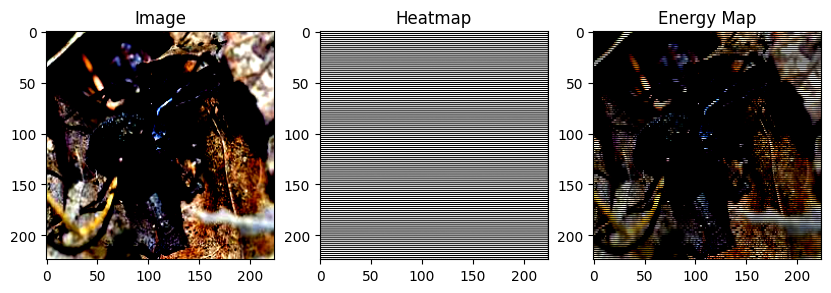

Predicted Label: horse, Actual Label: horse
Output: tensor([-0.5622, 10.4690, -0.6638, -1.1929, -1.2625, -1.6269,  1.5098, -1.8689,
        -2.0113,  0.6681], device='cuda:0')
Output_em: tensor([-0.3724, 10.5474,  0.6045, -1.4640, -1.6073, -1.4611,  1.0280, -1.7796,
        -2.0627,  0.0111], device='cuda:0')
Diff: tensor([0.1898, 0.0784, 1.2683, 0.2711, 0.3448, 0.1658, 0.4818, 0.0893, 0.0514,
        0.6570], device='cuda:0')
Heatmap min = 0.0, max = 1.0


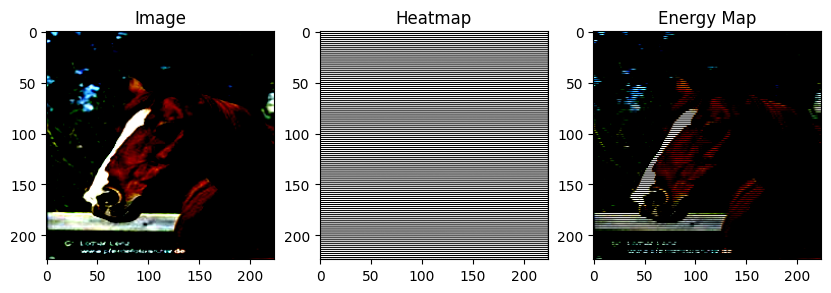

Predicted Label: cow, Actual Label: cow
Output: tensor([ 0.9393,  1.5163, -0.2815, -0.7441, -0.6284, -0.8628,  6.5156, -0.2738,
        -1.3561, -3.0430], device='cuda:0')
Output_em: tensor([-0.4420,  1.8011, -0.3110, -1.1648, -0.7527, -1.2562,  7.8726, -0.4321,
        -1.4812, -2.7896], device='cuda:0')
Diff: tensor([1.3812, 0.2847, 0.0295, 0.4207, 0.1243, 0.3933, 1.3570, 0.1583, 0.1251,
        0.2533], device='cuda:0')
Heatmap min = 0.0, max = 1.0


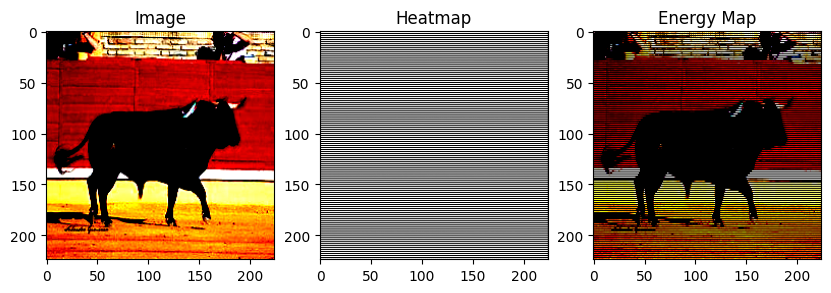

Predicted Label: cow, Actual Label: elephant
Output: tensor([ 0.2231,  0.9228,  2.1978, -1.1498, -1.3198,  0.2241,  3.2081,  0.5713,
        -1.6289, -1.4823], device='cuda:0')
Output_em: tensor([-0.3268, -1.0713,  4.9192, -1.6860, -0.2895, -0.7666,  1.9332,  0.0216,
        -0.9289, -1.5241], device='cuda:0')
Diff: tensor([0.5499, 1.9941, 2.7214, 0.5361, 1.0303, 0.9906, 1.2749, 0.5497, 0.7000,
        0.0418], device='cuda:0')
Heatmap min = 0.0, max = 1.0


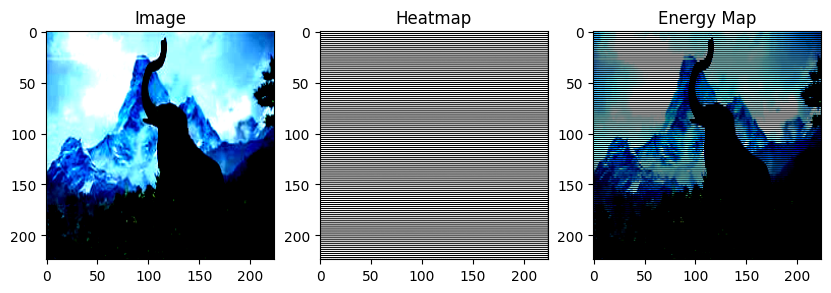

Predicted Label: chicken, Actual Label: chicken
Output: tensor([-1.0019, -1.4258, -2.1621, -0.5694, 12.9415, -2.6780, -1.8053, -0.3112,
        -1.5254, -2.1409], device='cuda:0')
Output_em: tensor([-1.0259, -1.4885, -1.4002, -1.8848, 13.4509, -2.4792, -2.4757, -0.3230,
        -1.2774, -0.4130], device='cuda:0')
Diff: tensor([0.0240, 0.0628, 0.7619, 1.3154, 0.5094, 0.1989, 0.6705, 0.0118, 0.2480,
        1.7280], device='cuda:0')
Heatmap min = 0.0, max = 1.0


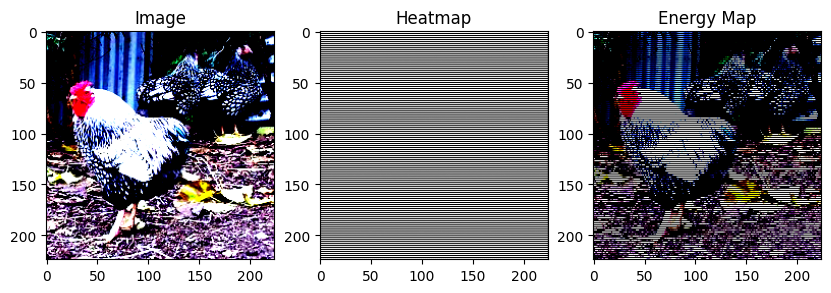

In [28]:
# normalize + MSE + CE + CE + diversity loss + threshold
model = Model_v2()
train(model, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=10, load_checkpoint=False) 
test_model_detailed(model, test_dataset, n_samples=5)

Predicted Label: spider, Actual Label: spider
Output: tensor([-2.2363, -0.6283, -0.9466,  0.2397, -0.3150, -0.7930, -1.7016, -1.7060,
         9.9121, -0.2635], device='cuda:0')
Output_em: tensor([-1.7484, -0.2691,  0.5586, -1.3716,  2.1272, -0.4326, -2.1125, -1.5538,
         7.0828, -0.9671], device='cuda:0')
Diff: tensor([0.4878, 0.3592, 1.5052, 1.6113, 2.4422, 0.3604, 0.4110, 0.1522, 2.8293,
        0.7036], device='cuda:0')
Heatmap min = 0.0, max = 1.0


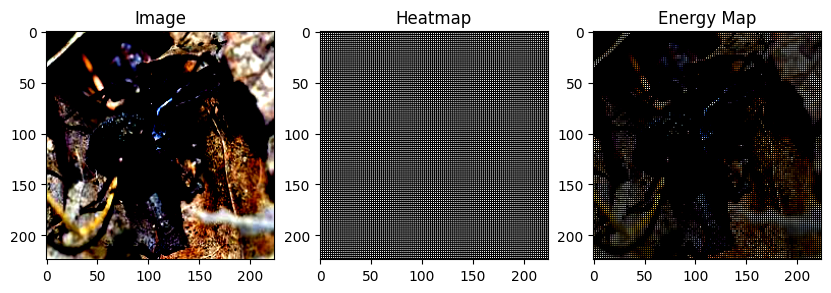

Predicted Label: horse, Actual Label: horse
Output: tensor([-0.2385,  8.8605, -0.3121, -2.6560, -1.8154, -1.1377,  0.6726, -1.3835,
        -1.7547, -0.5484], device='cuda:0')
Output_em: tensor([-0.7139,  4.5417,  6.2835, -1.6177, -0.0651, -2.1812, -1.6312, -0.9420,
        -1.3407, -1.5510], device='cuda:0')
Diff: tensor([0.4753, 4.3187, 6.5956, 1.0383, 1.7503, 1.0435, 2.3038, 0.4415, 0.4140,
        1.0026], device='cuda:0')
Heatmap min = 0.0, max = 1.0


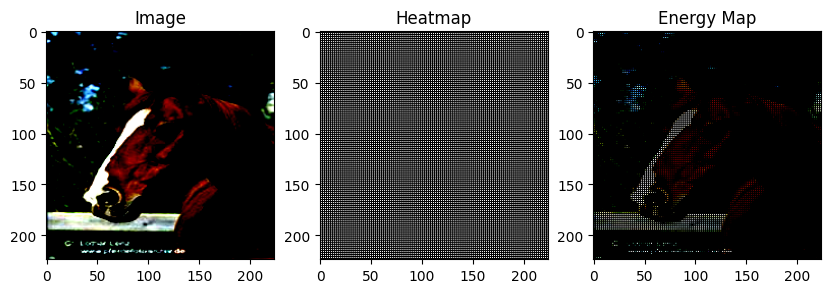

Predicted Label: cow, Actual Label: cow
Output: tensor([ 0.5984,  3.1919,  0.0997, -1.5169, -0.6045, -0.6367,  3.8802, -0.3329,
        -1.3152, -1.7015], device='cuda:0')
Output_em: tensor([-0.4312,  5.3378,  0.0404, -1.4724, -0.3690, -1.3242,  0.6573,  2.3712,
        -1.6617, -1.9888], device='cuda:0')
Diff: tensor([1.0296, 2.1459, 0.0593, 0.0446, 0.2355, 0.6875, 3.2229, 2.7041, 0.3465,
        0.2874], device='cuda:0')
Heatmap min = 0.0, max = 1.0


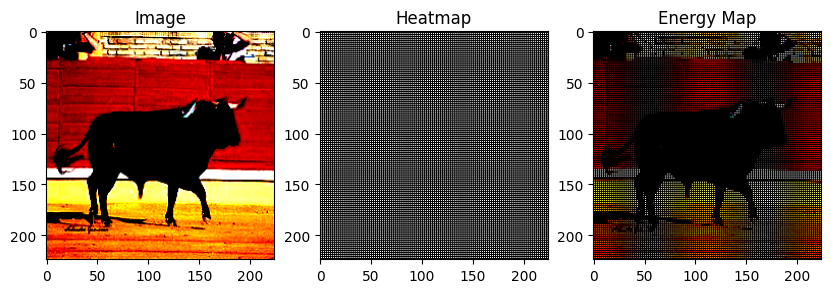

Predicted Label: elephant, Actual Label: elephant
Output: tensor([ 0.9035,  0.1547,  3.1618, -1.2995, -1.0256,  1.3918,  1.6400, -0.3964,
        -1.6256, -0.4588], device='cuda:0')
Output_em: tensor([-0.3039, -1.1354,  6.0596, -2.5907,  0.5050, -0.0518, -1.5266,  1.8878,
        -0.0316,  0.0092], device='cuda:0')
Diff: tensor([1.2073, 1.2901, 2.8978, 1.2911, 1.5306, 1.4435, 3.1667, 2.2842, 1.5941,
        0.4680], device='cuda:0')
Heatmap min = 0.0, max = 1.0


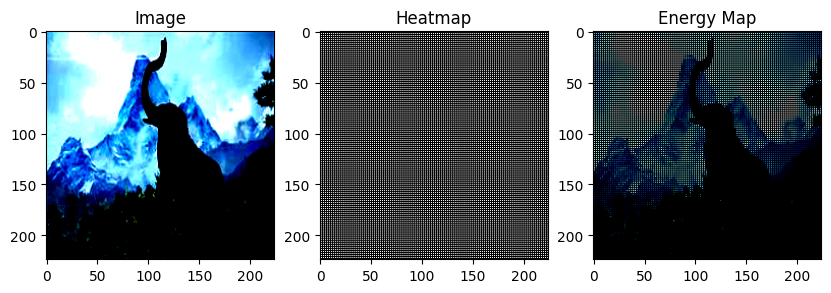

Predicted Label: chicken, Actual Label: chicken
Output: tensor([-1.0515, -1.5500, -1.4568, -1.1480, 12.7175, -1.7714, -1.6436, -1.8508,
        -1.1999, -0.4747], device='cuda:0')
Output_em: tensor([-1.1022, -2.2358, -1.3682, -1.3308, 12.7967, -1.6670, -2.1516, -2.0362,
        -0.9883,  0.3345], device='cuda:0')
Diff: tensor([0.0507, 0.6857, 0.0886, 0.1828, 0.0792, 0.1044, 0.5080, 0.1854, 0.2116,
        0.8092], device='cuda:0')
Heatmap min = 0.0, max = 1.0


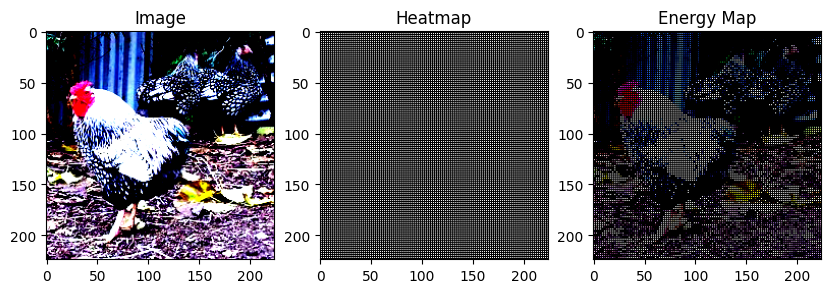

In [32]:
# normalize + MSE + CE + CE + diversity loss + L1
# model = Model_v2()
# train(model, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=10, load_checkpoint=False) 
test_model_detailed(model, test_dataset, n_samples=5)

In [ ]:
# Before training
model_v2 = Model_v2()
model_v2.to(device)
# test_model(model_v2, test_dataset)
# view_heatmaps(model_v2, dataset, n_examples=3)
test_model_detailed(model_v2, test_dataset, n_samples=3)

In [ ]:
# Training v2 model
# losses_accuracies = train(model_v2, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=20, load_checkpoint=True, 
#                          checkpoint_path='checkpoint_20-11-23:13-44-58.pt') 
losses_accuracies = train(model_v2, train_dataset, validation_dataset, batch_size=32, lr=0.001, max_epochs=10, load_checkpoint=False) 

In [ ]:
# test_model(model_v2, test_dataset)
# view_heatmaps(model_v2, dataset, n_examples=3)
test_model_detailed(model_v2, test_dataset, n_samples=4)

In [ ]:
# test_model(model_v2, test_dataset)
# view_heatmaps(model_v2, dataset, n_examples=3)
test_model_detailed(model_v2, test_dataset, n_samples=3)

In [ ]:
# After training
test_model(model_v2, test_dataset)
# view_heatmaps(model_v2, dataset, n_examples=3)
test_model_detailed(model_v2, test_dataset, n_samples=3)

In [ ]:
# losses, accuracies = train(model, train_dataset, validation_dataset, batch_size=32, lr=0.01, max_epochs=50, load_checkpoint=True, checkpoint_path="checkpoint_18-11-23:18-53-19.pt") 
# make_plots(losses, accuracies)
test_model(model, test_dataset)

In [ ]:
test_model_detailed(model, test_dataset, n_samples=10)

In [ ]:
view_heatmaps(model, dataset, n_examples=10)

In [ ]:
# Model trained only with CE and MSE loss
losses, accuracies = train(model, train_dataset, validation_dataset, batch_size=32, lr=0.01, max_epochs=50, load_checkpoint=True, checkpoint_path="checkpoint_10-11-23:11-37-58.pt") 
make_plots(losses, accuracies)
test_model(model, test_dataset)

In [ ]:
test_model_detailed(model, test_dataset, n_samples=20) # checkpoint_10-11-23:11-37-58.pt

In [ ]:
# Model trained with CE + MSE + L1 losses
losses, accuracies = train(model, train_dataset, validation_dataset, batch_size=32, lr=0.01, max_epochs=50, load_checkpoint=True, checkpoint_path="checkpoint_10-11-23:15-08-33.pt") 
make_plots(losses, accuracies)
test_model(model, test_dataset)

In [ ]:
test_model_detailed(model, test_dataset) # checkpoint_10-11-23:15-08-33.pt

In [ ]:
view_heatmaps(model, test_dataset, n_examples=10)